In [57]:
import os
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import numpy as np

from utils.conn_data import load_pickle

warnings.filterwarnings('ignore')

plt.style.use('ggplot')

In [58]:
outputs_path = os.path.join(os.path.dirname(os.getcwd()), "src", "data", "outputs")
des = pd.read_csv(os.path.join(os.path.dirname(os.getcwd()), "src", 'data', 'utils', 'fredmd_description.csv'), sep=';')

# fs_methods = ["lasso", "multivariate-granger", "pairwise-granger", "var-lingam", "dynotears"]
fs_methods = ["lasso", "var-lingam"]
metric_names = ["stability", "mse", "mae"]
etf_focus = None
stability_threshold = 0.8
plot_ts = False

In [59]:
all_parents = []
for fs in fs_methods:
    results_files = glob.glob(os.path.join(outputs_path, fs, "etfs_macro_large", "*.pickle"))

    for file in results_files:
        etf = file.split(fs)[-1].split("/")[-1].split("_")[0]
        obj = load_pickle(path=file)
        parents_of_target_df = obj["parents_of_target"]

        parents_of_target_df["etf"] = etf
        parents_of_target_df["fs"] = fs

        all_parents.append(parents_of_target_df)
all_parents_df = pd.concat(all_parents)

## Parents over time

<AxesSubplot:xlabel='None-cluster', ylabel='date'>

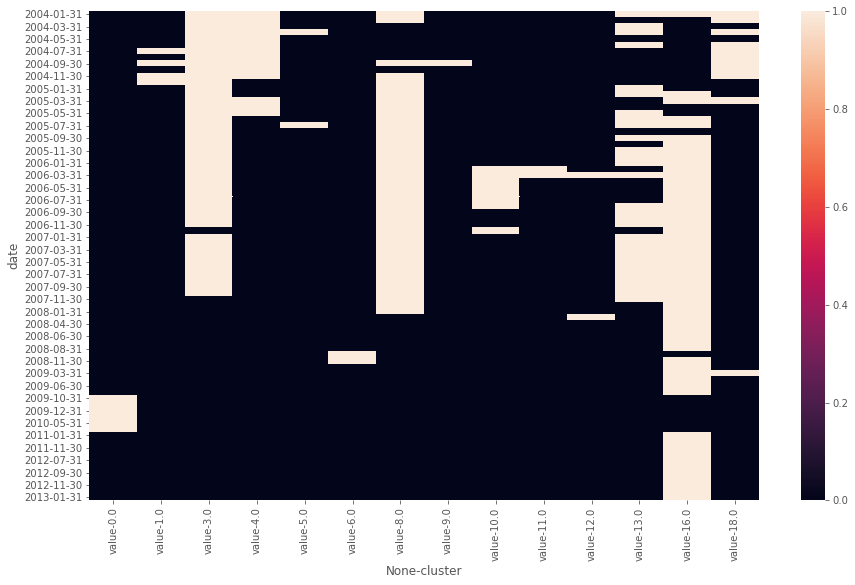

In [60]:
etf = "XLE"
fs = "var-lingam"

check_df = all_parents_df.loc[(all_parents_df['etf'] == etf)&(all_parents_df['fs'] == fs)].drop(["etf", "fs"], axis=1)
check_df["date"] = [pd.to_datetime(dtref).strftime('%Y-%m-%d') for dtref in check_df["date"]]

plt.figure(figsize=(15, 9))
sns.heatmap(check_df.pivot_table(index=["date"], columns=["cluster"], values=["value"]).fillna(0))

## Average Number of Parents

In [69]:
avgs = []
for fs in all_parents_df["fs"].unique():
    for etf in all_parents_df["etf"].unique():
        check_df = all_parents_df.loc[(all_parents_df['etf'] == etf)&(all_parents_df['fs'] == fs)].drop(["etf", "fs"], axis=1)

        mean = check_df.pivot_table(index=["date"], columns=["cluster"], values=["value"]).sum(axis=1).mean()
        std = check_df.pivot_table(index=["date"], columns=["cluster"], values=["value"]).sum(axis=1).std()
        skew = check_df.pivot_table(index=["date"], columns=["cluster"], values=["value"]).sum(axis=1).skew()

        avgs.append({"fs": fs, "etf": etf, "mean": mean, "std": std, "skew": skew})
avgs_df = pd.DataFrame(avgs)

In [71]:
avgs_df.sort_values(by=["mean"], ascending=False)

,fs,etf,mean,std,skew
4,lasso,XLY,4.076190,1.833736,0.046435
18,var-lingam,XLP,3.428571,2.792353,0.817483
12,var-lingam,XLF,3.106061,2.779755,1.442640
3,lasso,SPY,3.014851,1.231743,-0.254331
10,var-lingam,XLE,2.848101,1.593968,0.196776
6,lasso,XLB,2.823529,1.217977,-0.034262
0,lasso,XLE,2.560976,0.787425,0.891639
17,var-lingam,XLV,2.486486,2.952794,1.876036
7,lasso,XLV,2.470588,1.742246,1.150355
14,var-lingam,XLY,2.441176,2.667563,1.778321


## New Stability measure

In [64]:
ticker = "SPY"
etf_df = all_parents_df[(all_parents_df["etf"] == ticker)]
etf_df.loc[:, "date"] = [dtref.strftime("%Y-%m-%d") for dtref in etf_df["date"]]

etf_df = etf_df.sort_values(by=["date"])
all_scores = []
for fs in etf_df["fs"].unique():
    fs_etf_df = etf_df[etf_df["fs"] == fs]

    score = []
    for i, date in enumerate(fs_etf_df["date"].unique()):
        if i == 0:
            F_t = F_tm1 = set(fs_etf_df.loc[fs_etf_df["date"] == date]["cluster"].dropna().values)
            s = 0
        else:
            F_t = set(fs_etf_df.loc[fs_etf_df["date"] == date]["cluster"].dropna().values)
            s = len(F_tm1.intersection(F_t)) / len(F_tm1.union(F_t)) if len(F_tm1.union(F_t)) != 0 else np.nan
            F_tm1 = F_t
        score.append({"date": date, "score": s})
    score_df = pd.DataFrame(score)
    score_df["fs"] = fs

    melt_score_df = score_df.melt(["date", "fs"])
    all_scores.append(melt_score_df)
all_scores_df = pd.concat(all_scores).drop("variable", axis=1)

### (a) Stability Measure over time

<AxesSubplot:xlabel='date'>

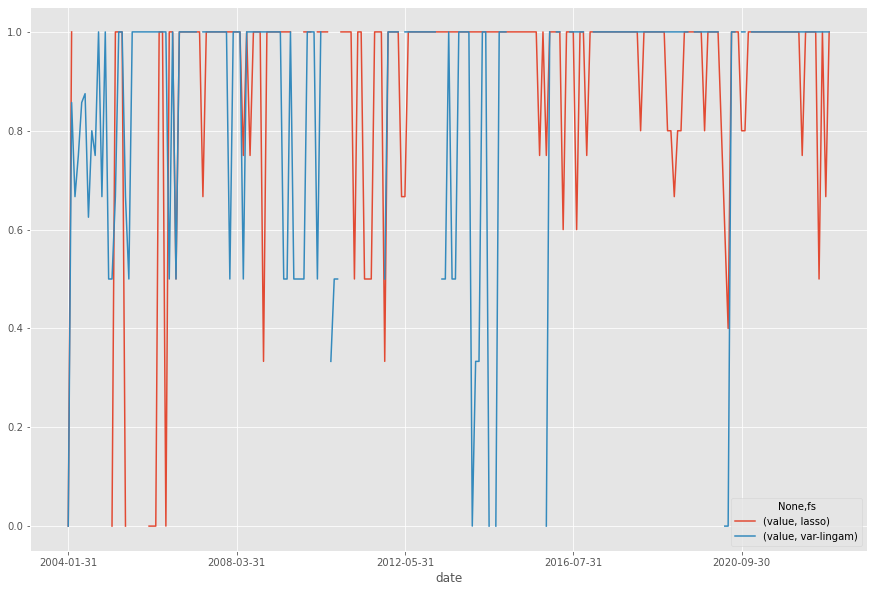

In [65]:
all_scores_df.pivot_table(index=["date"], columns=["fs"], values=["value"]).plot(figsize=(15, 10))

### (b) Average Stability Measure

In [66]:
all_scores_df.groupby(["fs"])[["value"]].mean().sort_values(by=["value"], ascending=False)

,value
fs,
lasso,0.904390
var-lingam,0.879023
